## Protocole 1 : Vérification des Performances d'une Carte Arduino

Ce protocole a pour but de vérifier la précision et la stabilité temporelle d'une carte Arduino en générant un signal périodique (triggers) et en l'analysant.

### Prérequis

**Matériel :**
*   Une carte Arduino (ex: Uno, Nano etc. ici Leonardo)
*   Un câble USB (micro-USB ou USB-C selon la carte)
*   Un oscilloscope numérique ou un dispositif d'acquisition (ici Analog Discovery 3)

**Logiciels :**
*   **Arduino IDE** (ici version `1.8.19`)
*   Logiciel d'acquisition et de mesure (ici **Digilent Waveforms**, version `3.24.2`)
*   Un environnement **Python 3** avec les bibliothèques nécessaires (`pandas`, `numpy`, `matplotlib`, `scipy`).

### Étapes à suivre

#### 1. Génération des Triggers sur Arduino

1.  **Préparez le code Arduino (.ino)** qui génère des triggers sur un pin (ici le pin 8) en prenant en argument la période désirée.

    > **Code Arduino (.ino) pour la génération périodique automatique de triggers via TimerOne.**
    >
    >     // Utilise la librairie TimerOne : https://www.pjrc.com/teensy/td_libs_TimerOne.html
    >     #include <TimerOne.h>
    >
    >     const int triggerPin = 8;       // Sortie TTL sur la pin 8
    >     const unsigned long period_us = 500000;   // Période = 500 ms
    >     const unsigned long pulse_width_us = 1000; // Largeur du pulse = 1 ms
    >
    >     void setup() {
    >       pinMode(triggerPin, OUTPUT);
    >       digitalWrite(triggerPin, LOW);
    >
    >       Timer1.initialize(period_us);         // Timer déclenché toutes les 500 ms
    >       Timer1.attachInterrupt(trigger);      // Fonction appelée à chaque tick
    >     }
    >
    >     void loop() {
    >       // Le timer fait tout, rien à faire ici
    >     }
    >
    >     void trigger() {
    >       digitalWrite(triggerPin, HIGH);
    >       delayMicroseconds(pulse_width_us);    // Pulse de 1 ms
    >       digitalWrite(triggerPin, LOW);
    >     }


2.  **Branchez la carte Arduino** à l'ordinateur via le port USB.

3.  **Ouvrez l'IDE Arduino** et vérifiez que la carte est correctement reconnue (`Tools > Board > "nom_de_votre_carte_arduino"`) et que le bon port est sélectionné (`Tools > Port`).
    > *[Image : Menu "Tools" de l'IDE Arduino déroulé, montrant la sélection de la carte et du port.]*

4.  **Vérifiez puis téléversez le code** sur la carte en utilisant les boutons dédiés.
    > 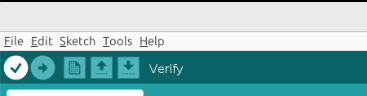
    > 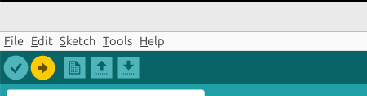
5.  Attendez que le message de confirmation `Done uploading.` apparaisse en bas de la fenêtre.
    > 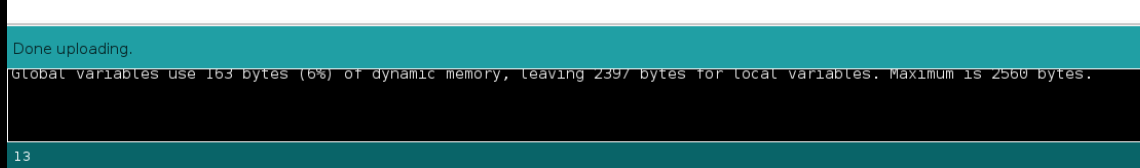

La carte devrait maintenant générer des triggers sur le pin concerné.

#### 2. Mesure des Triggers

1.  **Connectez l'oscilloscope** à la carte Arduino :
    *   Branchez la sonde de masse (GND) de l'oscilloscope à l'une des broches **GND** de l'Arduino.
    *   Branchez la sonde de mesure (Canal 1) au **pin 8** de l'Arduino.

2.  **Lancez le logiciel Waveforms** (ou équivalent). Cliquez sur **`Scope`**
    >![Screenshot from 2025-06-16 15-24-05.png](<attachment:Screenshot from 2025-06-16 15-24-05.png>)
    >![Screenshot from 2025-06-16 15-24-14.png](<attachment:Screenshot from 2025-06-16 15-24-14.png>)

3. Cliquez sur **`Run`** pour démarrer l'acquisition. Vous devriez observer des pics/créneaux sur le canal correspondant à vos branchements.
    > ![Screenshot from 2025-06-16 15-23-47.png](<attachment:Screenshot from 2025-06-16 15-23-47.png>)

4.  Vous pouvez étudier à l'œil le signal (période, amplitude, rapport cyclique) en **changeant l’échelle des axes**.
    > ![Screenshot from 2025-06-16 15-22-55.png](<attachment:Screenshot from 2025-06-16 15-22-55.png>)

#### 3. Enregistrement du Signal

1.  Cliquez sur le bouton **`Record`**.
    > 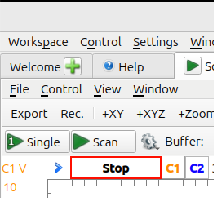

2.  Configurez les paramètres d'enregistrement :
    *   **Format du fichier :** `.csv`
    *   **Fréquence d'échantillonnage :** `10 kHz`
    *   **Durée d’enregistrement :** `20 s`
    *   **Emplacement et nom de votre fichier.**
    > ![Screenshot from 2025-06-16 15-39-33.png](<attachment:Screenshot from 2025-06-16 15-39-33.png>)

3.  Lancez l’enregistrement. Vous avez alors un fichier `.csv` comportant le signal mesuré.

#### 4. Analyse du Signal

1.  **Préparez le script Python**. Le code doit permettre l’étude du fichier `.csv` en choisissant un seuil de détection, un intervalle minimum entre les pics, et d'autres paramètres. Il doit étudier les intervalles min, max et moyen, générer un histogramme de la répartition des intervalles, et compter le nombre de pics et d'intervalles.

    > **Code Python (.py) pour l’analyse de la régularité des triggers depuis un fichier CSV.**
    >
    >     import numpy as np
    >     import matplotlib
    >     matplotlib.use('Agg')  # Utilisation d'un backend non-interactif
    >
    >     import matplotlib.pyplot as plt
    >     from scipy.signal import find_peaks
    >     import os
    >
    >     # --- Paramètres ---
    >     NOM_FICHIER_CSV = 'triggers_arduino_better_500ms.csv'
    >     COLONNE_SIGNAUX = 0           # index de la colonne à analyser
    >     SAMPLING_RATE = 10000         # Hz (échantillonnage utilisé lors de l'acquisition)
    >     DISTANCE_MIN_MS = 1.0         # Distance minimale entre deux pics (en ms)
    >
    >     def analyser_et_sauvegarder_graphique_csv(nom_fichier):
    >         try:
    >             data = np.loadtxt(nom_fichier, delimiter=',')
    >
    >             print(f"--- Analyse du fichier CSV : {nom_fichier} ---")
    >             print(f"Taux d'échantillonnage utilisé : {SAMPLING_RATE} Hz (calculé à 50% de l'amplitude max)")
    >
    >             # Gérer 1D ou 2D
    >             if data.ndim == 1:
    >                 signal = data
    >                 print("Le fichier contient une seule colonne, elle sera utilisée.")
    >             else:
    >                 signal = data[:, COLONNE_SIGNAUX]
    >                 print(f"Le fichier contient {data.shape[1]} colonnes, utilisation de la colonne {COLONNE_SIGNAUX}.")
    >
    >             signal_abs = np.abs(signal)
    >             seuil = 0.5 * np.max(signal_abs)
    >             print(f"Seuil de détection (absolu) : {seuil:.2f}")
    >
    >             distance_min_samples = int(DISTANCE_MIN_MS * SAMPLING_RATE / 1000)
    >             print(f"Distance minimale entre pics : {DISTANCE_MIN_MS} ms")
    >
    >             indices_pics, _ = find_peaks(signal_abs, height=seuil, distance=distance_min_samples)
    >             intervalles_en_samples = np.diff(indices_pics)
    >             intervalles_en_ms = (intervalles_en_samples / SAMPLING_RATE) * 1000
    >
    >             print("\n--- RÉSULTATS ---")
    >             print(f"Nombre de pics détectés : {len(indices_pics)}")
    >             print(f"Nombre total d'intervalles : {len(intervalles_en_ms)}")
    >
    >             if len(intervalles_en_ms) > 0:
    >                 moyenne = np.mean(intervalles_en_ms)
    >                 print(f"Intervalle moyen : {moyenne:.2f} ms")
    >                 print(f"Intervalle min : {np.min(intervalles_en_ms):.2f} ms")
    >                 print(f"Intervalle max : {np.max(intervalles_en_ms):.2f} ms")
    >
    >                 plt.figure(figsize=(12, 7))
    >                 plt.hist(intervalles_en_ms, bins=50, edgecolor='black', alpha=0.75)
    >                 plt.axvline(moyenne, color='red', linestyle='--', linewidth=2,
    >                             label=f'Moyenne = {moyenne:.2f} ms')
    >                 plt.title(f"Distribution des intervalles\nFichier: {o


2.  **Lancez le code**.
>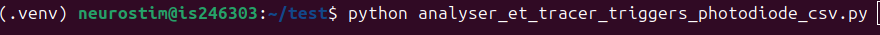

3.  Vous avez désormais affiché sur le terminal les différentes caractéristiques du signal et un histogramme que vous pouvez retrouver au chemin d'accès renseigné.
    > 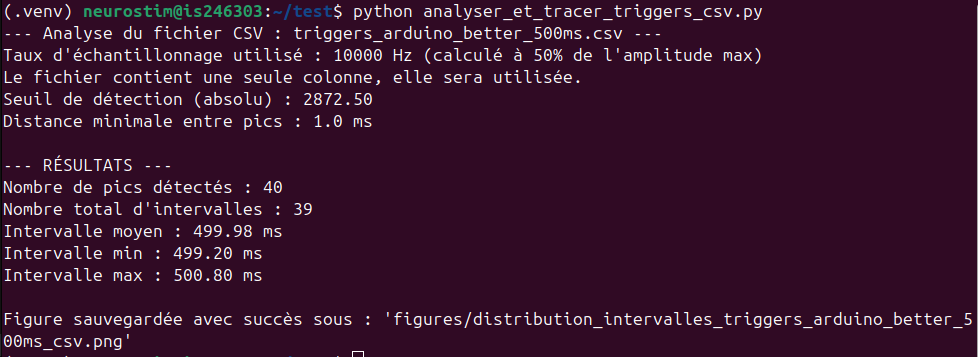
    > 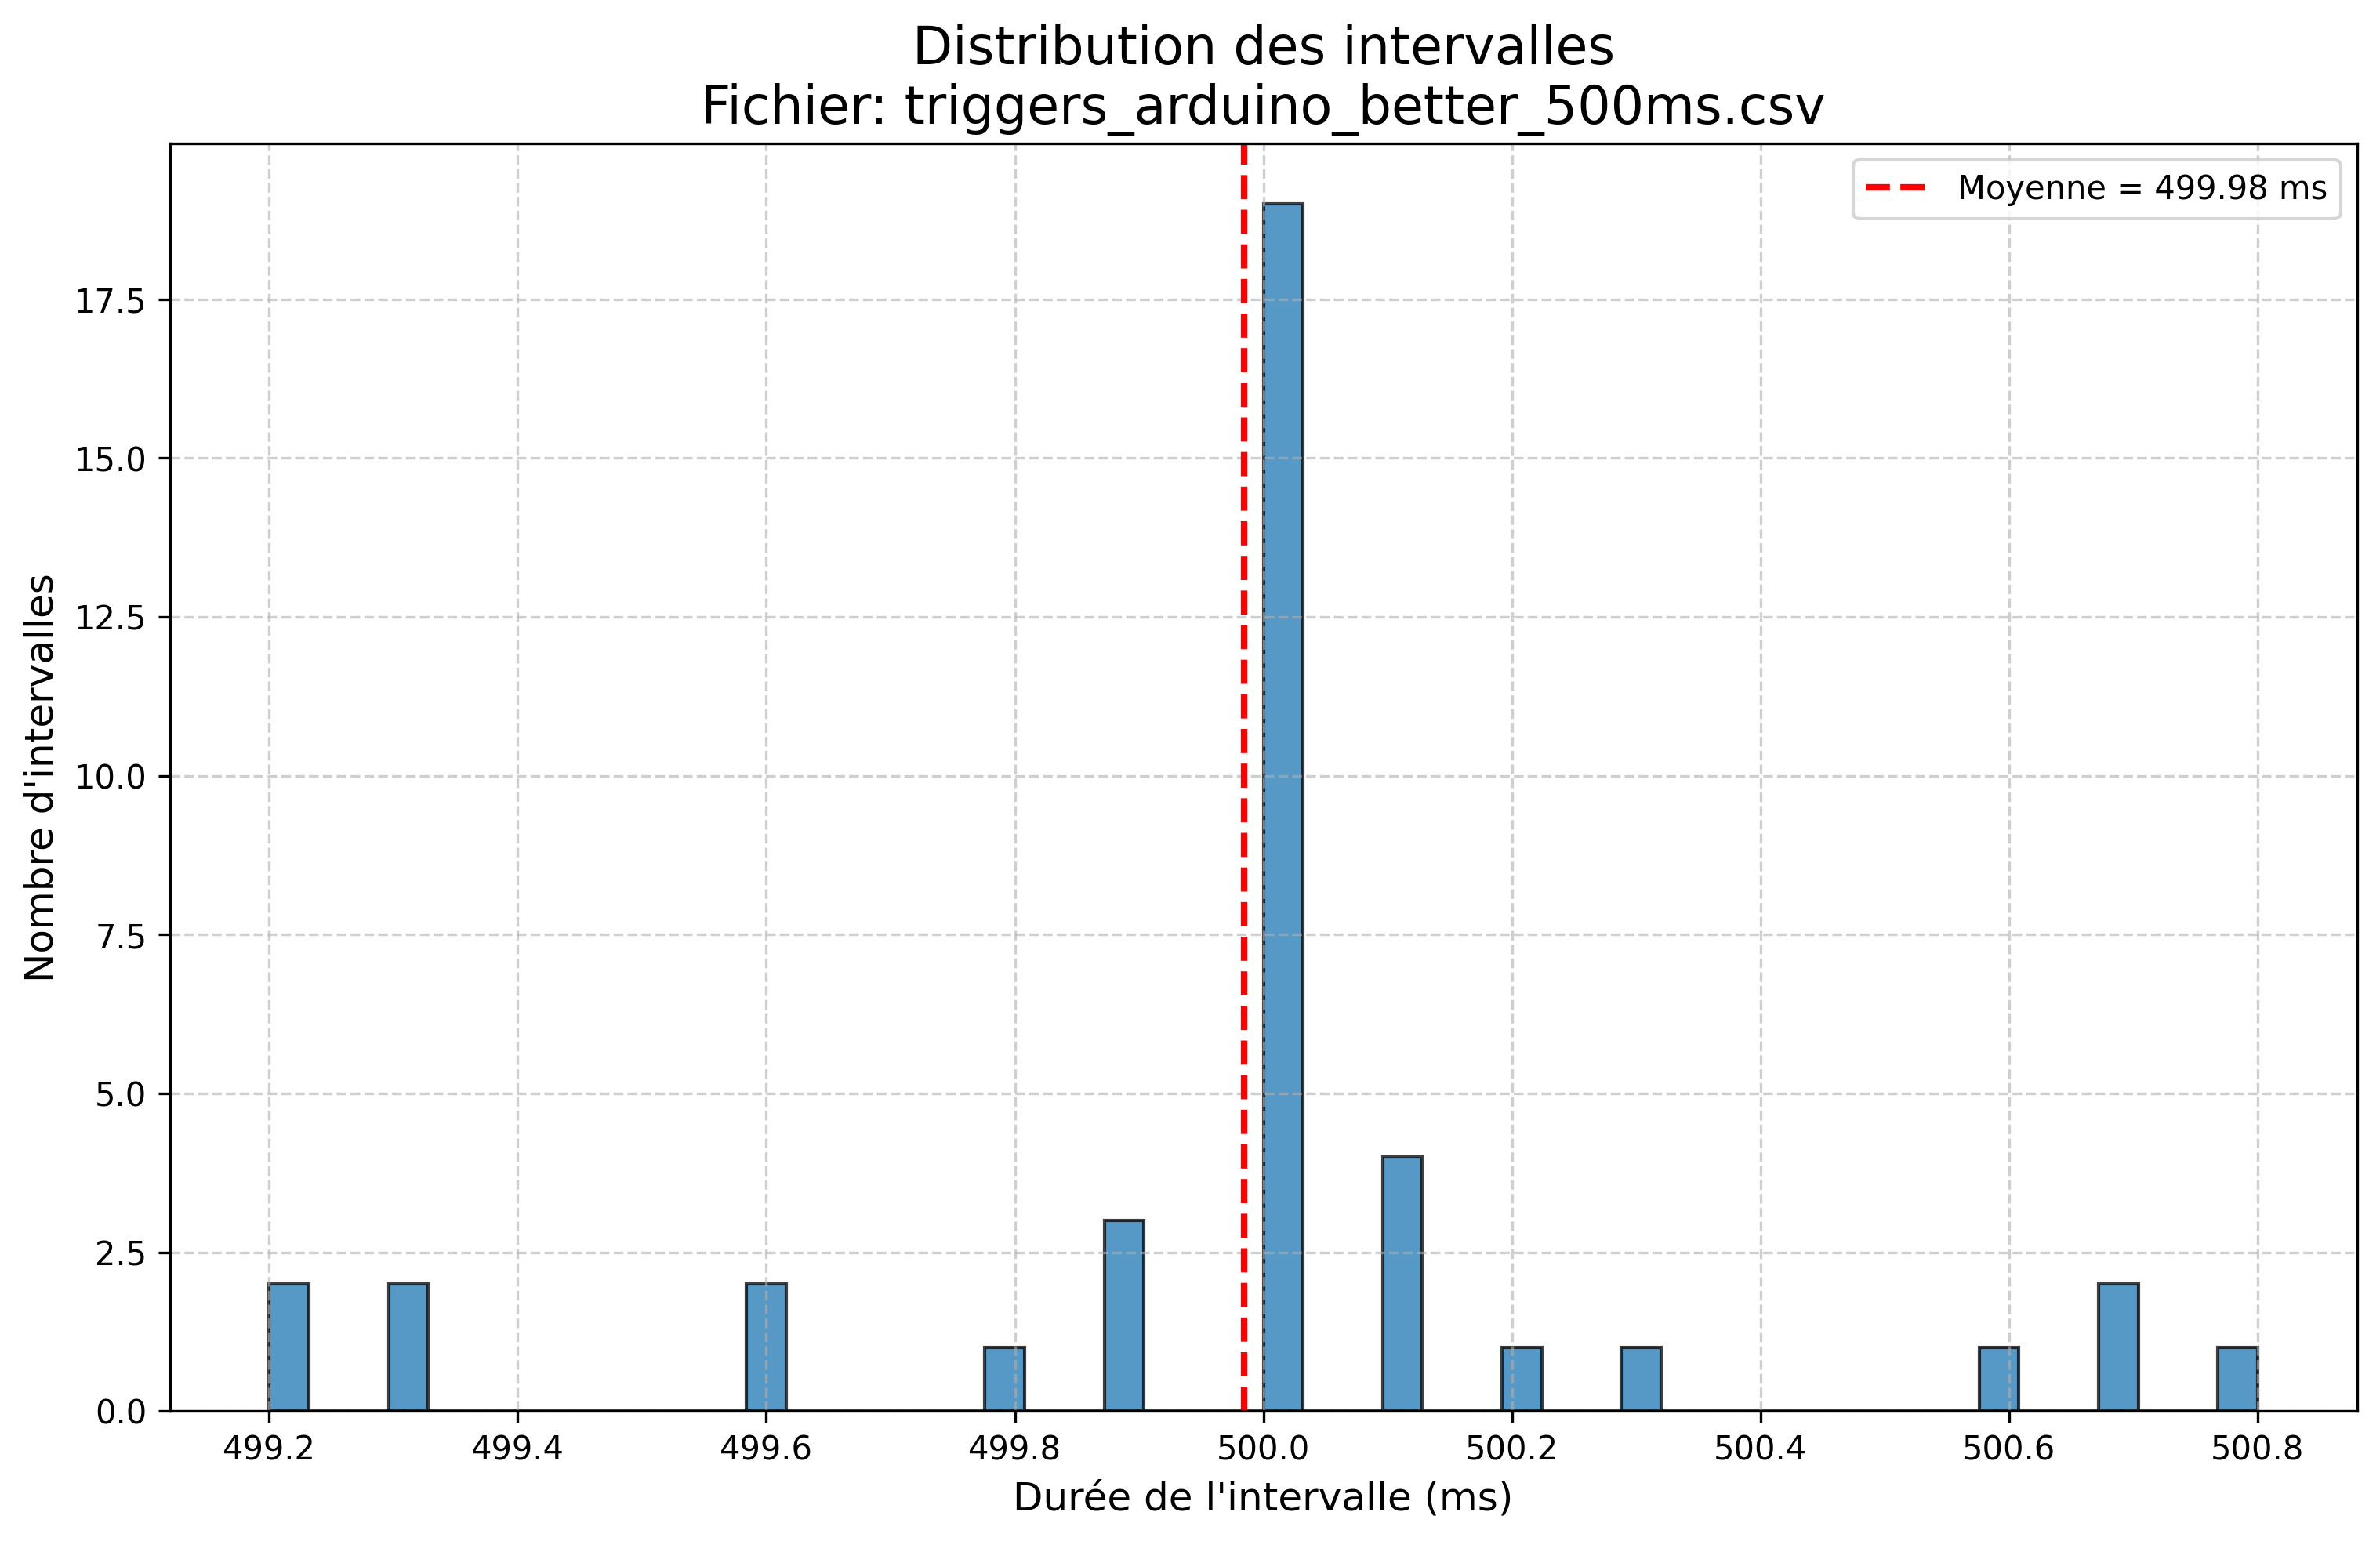

#### Pour aller plus loin

Reproduisez ce protocole en faisant varier la période dans votre code Arduino pour étudier les performances de manière plus approfondie.


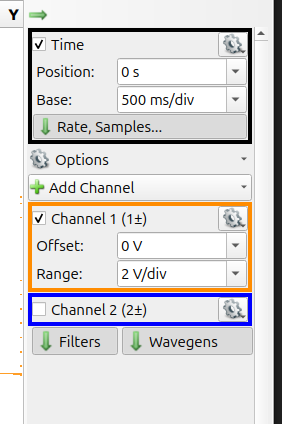
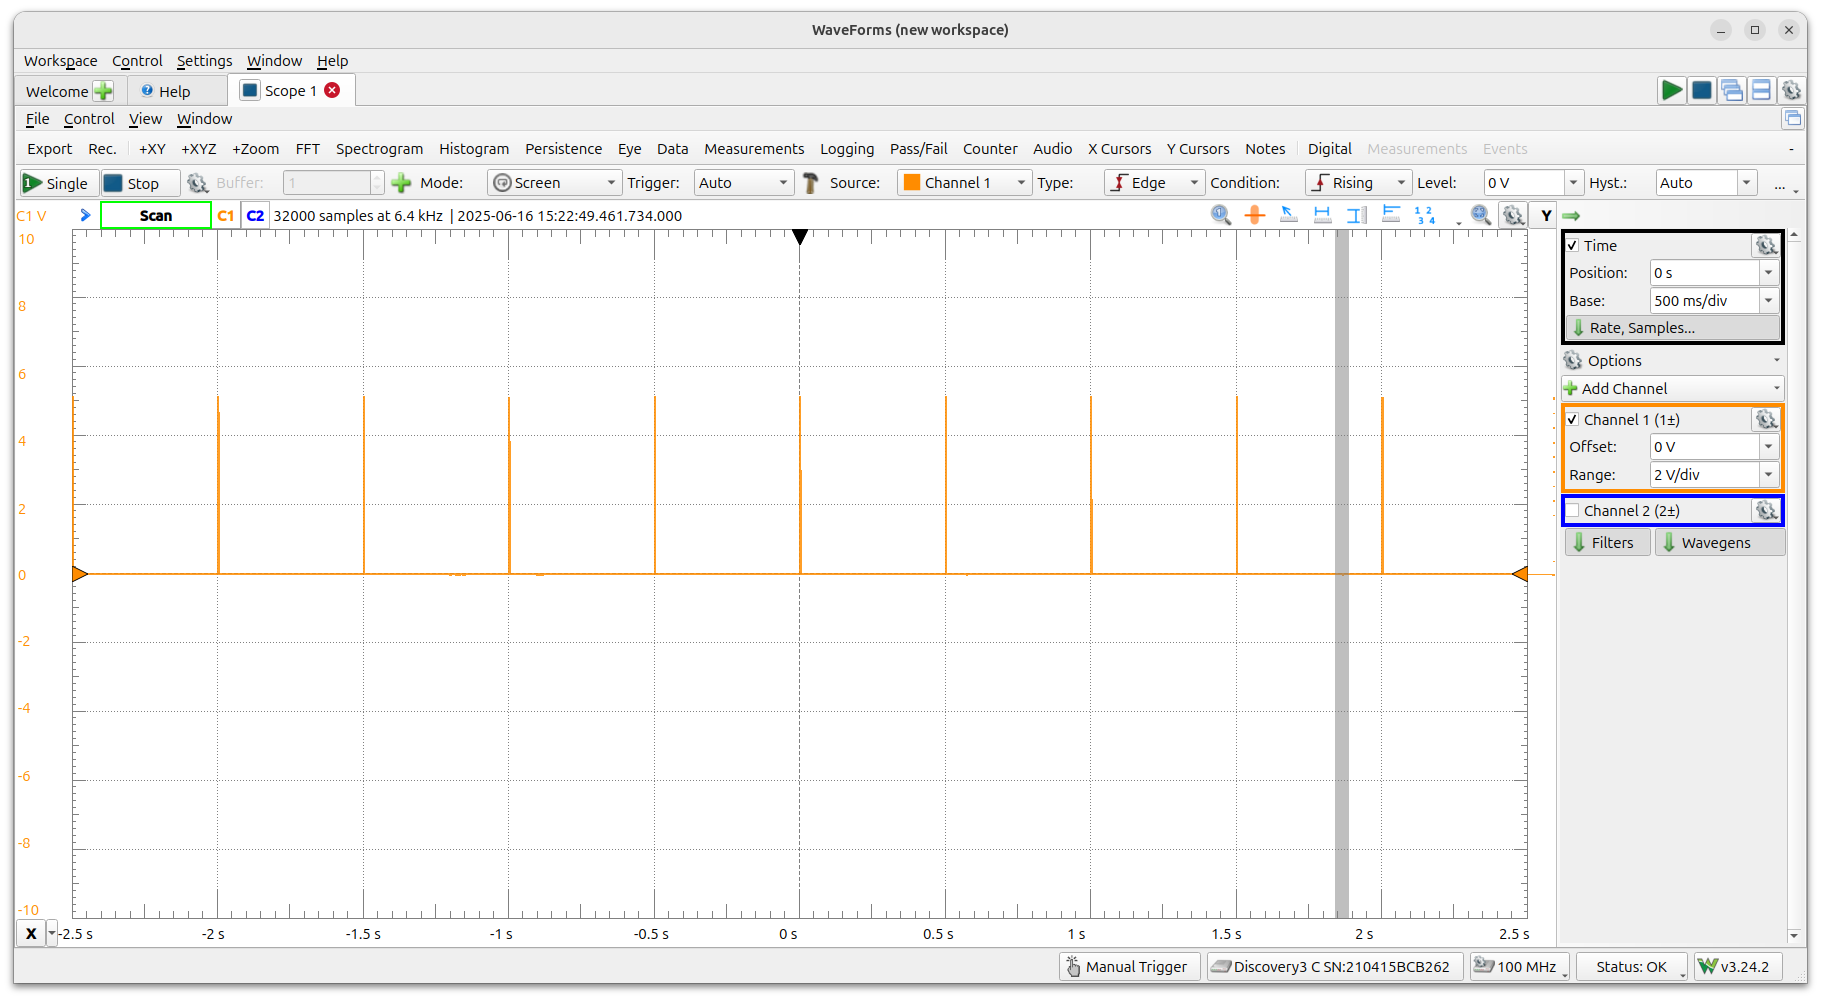
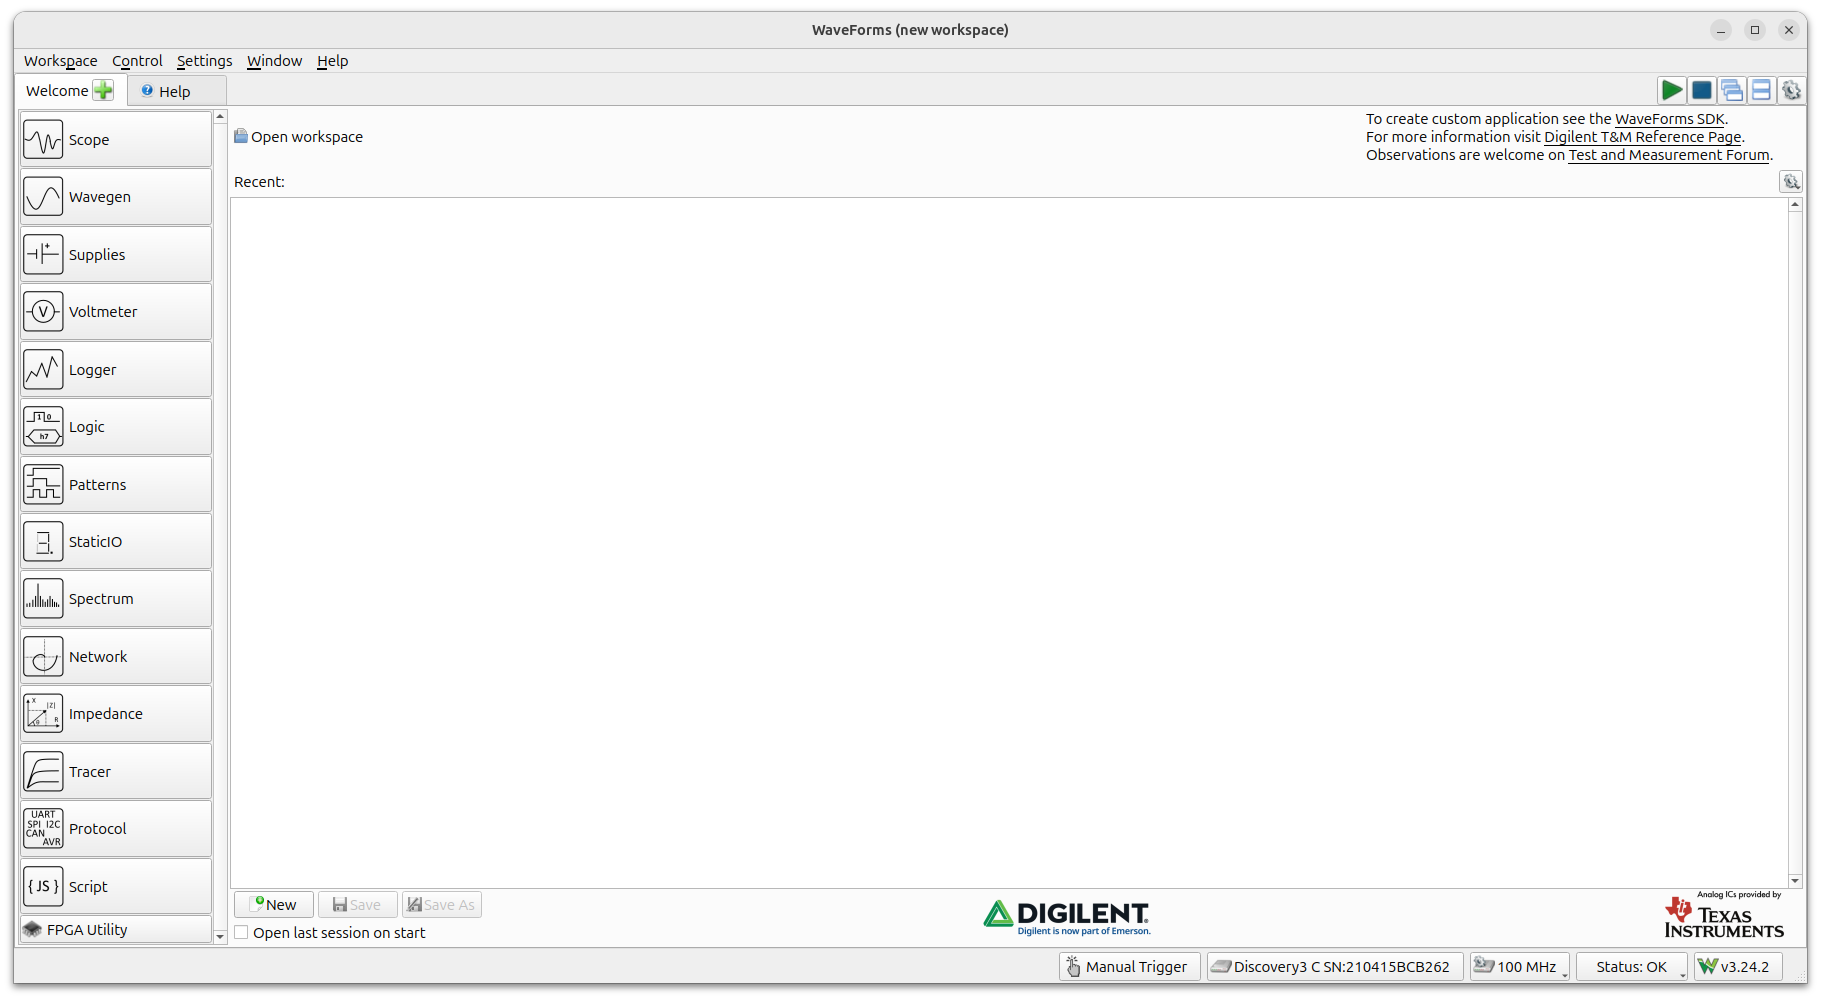
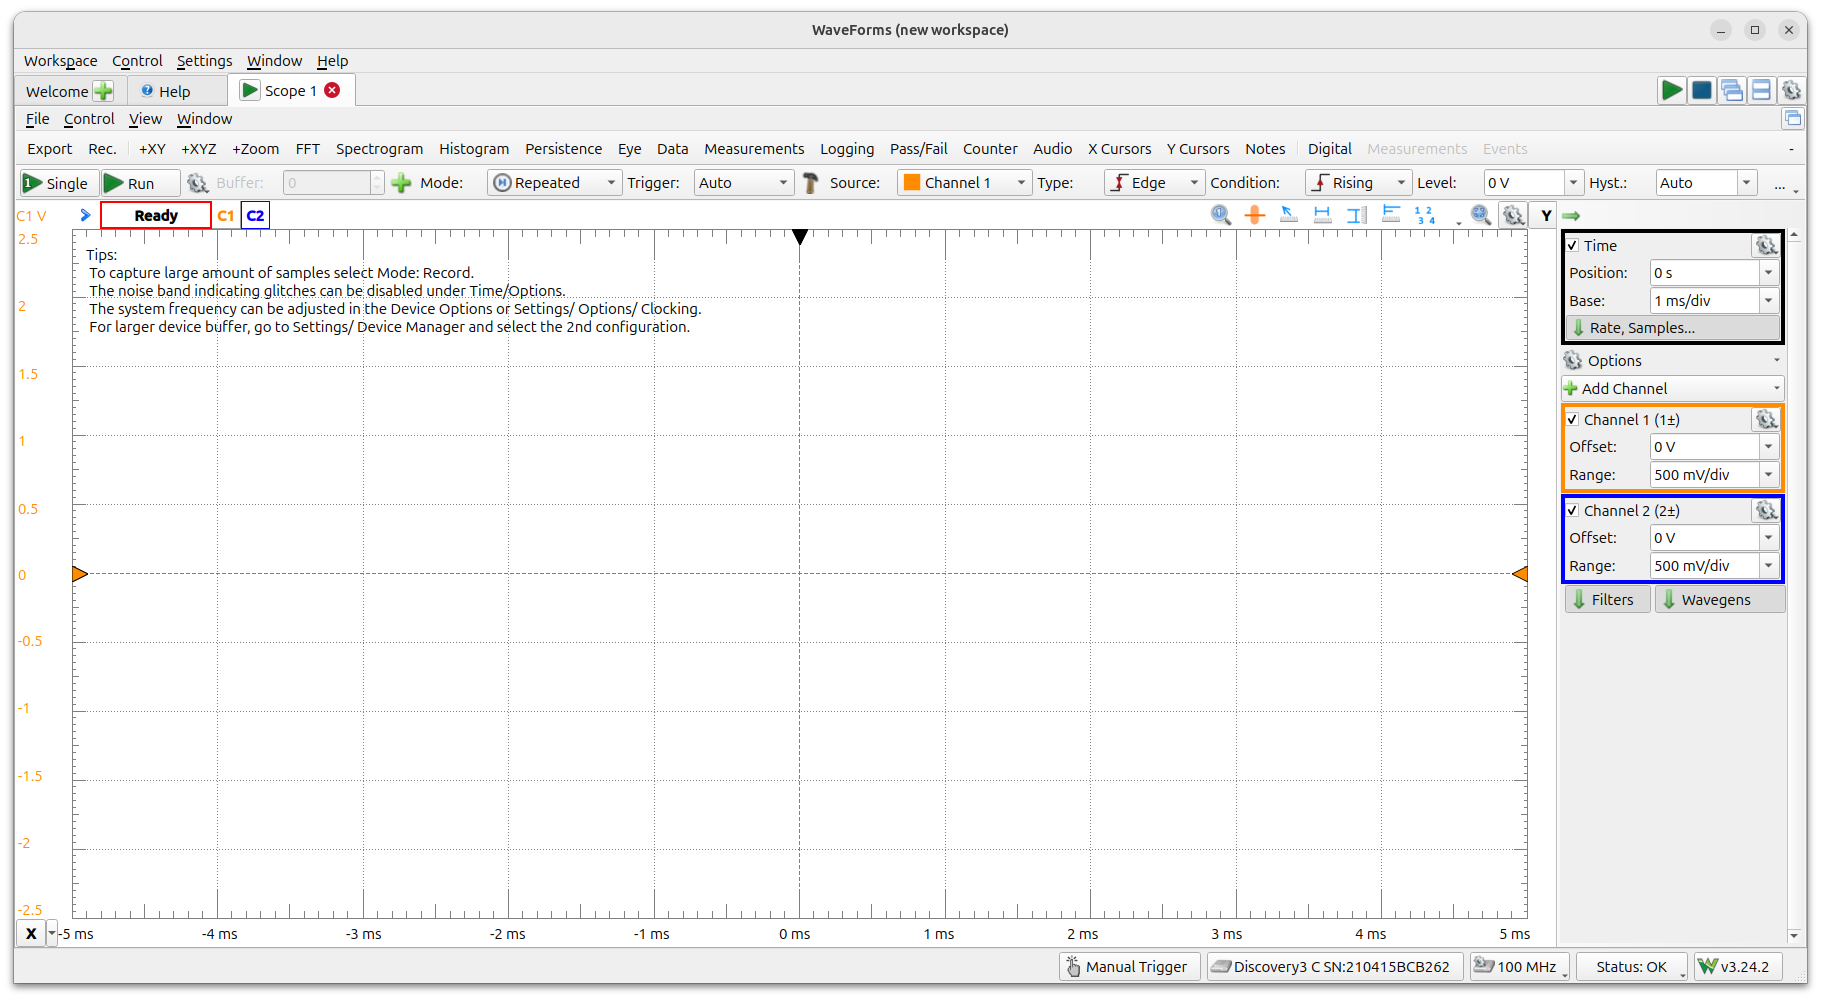
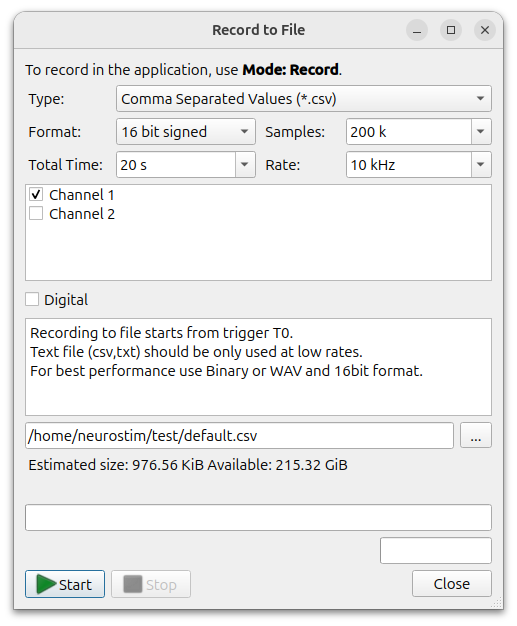